# M1. Actividad
Sofía Margarita Hernández Muñoz
A01655084

## Descripción de la actividad

Esta actividad consta de simular mediante un sistema multiagente el comportamiento de robots de limpieza reactivos los cuales se inicializaran en la coordenada [1, 1] de una habitación de tamaño MxN además de tener la capacidad de moverse a una de sus 8 celdas vecinas. En la habitación también se encontrarán celdas sucias con tierra, por lo que si un robot se encuentra en una celda con tierra este lo limpia.

### Parámetros iniciales para la creación del modelo
- Habitación de MxN espacios.
- Número de agentes.
- Porcentaje de celdas inicialmente sucias.
- Tiempo máximo de ejecución.

### Información recopilada
- Tiempo necesario hasta que todas las celdas estén limpias (o se haya llegado al tiempo máximo).
- Porcentaje de celdas limpias después del termino de la simulación.
- Número de movimientos realizados por todos los agentes.

## Ambiente

El ambiente es **no determinista** pues al simular el modelo en diferentes ocasiones con los mismos parámetros este genera resultados diferentes pues los robots son capaces de elegir una celda aleatoria para moverse.

El ambiente es **dinámico** ya que cambia mientras un agente está en proceso de responder a un percepto; al existir diferentes robots mientras el `robot 1` se está moviendo el `robot 2` puede estar limpiando una celda lo que ocasiona que el ambiente cambie.

El ambiente es **discreto** pues se establece el número de perceptos, en este caso el porcentaje de celdas sucias, así como el tiempo máximo de ejecución.

## Agentes

Para este modelo se contemplan dos Agentes:
1. Vacuum
2. Dirt

Unicamente el agente `Vacuum` recibe información sensorial del entorno (perceptos) y genera acciones acorde a esta, lo que significa que es **reactivo**. El agente `Dirt` funciona como percepto en el ambiente.

El agente `Vacuum` se inicializa con un estado de `Iniciando`, el cual se va modificando a `Aspirando` o `Moviendo` dependiendo la acción que realice el agente.

Si alguno de los robots se encuentra con un agente `Dirt` lo *aspira* por lo que lo elimina del ambiente.

## Análisis individual

El primer analisís consta de crear un modelo con una habitación de tamaño `10x10`, iniciando con `10` aspiradoras, el `50%` de las celdas sucias y un tiempo máximo de `101` turnos.

In [2]:
from VacuumModel import VacuumModel

# Create the model
# width, height, N, dirtyCells, max_steps = 100
model = VacuumModel(10, 10, 6, 0.5, 101)

model.run_model()

# Get the data of the model
model_data = model.datacollector.get_model_vars_dataframe()

Se puede observar que mientras los turnos pasan la cantidad de celdas sucias va reduciendose, por lo que las aspiradoras inteligentes están funcionando de manera correcta.

Last step:  102


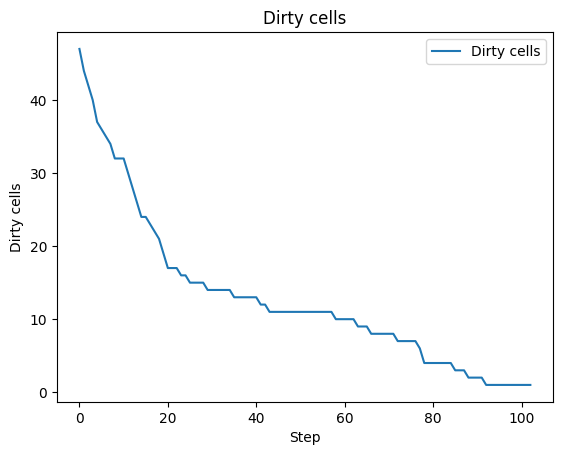

In [3]:
# Dirty cells data
dirty_cells_data = model_data[["Dirty cells"]]
plot = dirty_cells_data.plot(title="Dirty cells")

# Label the axes
plot.set_xlabel("Step")
plot.set_ylabel("Dirty cells")

# Get last step
last_step = model.schedule.steps
print("Last step: ", last_step)


De la misma manera, también podemos observar las veces que cada aspiradora se movio por el ambiente.

Text(0, 0.5, 'Moves')

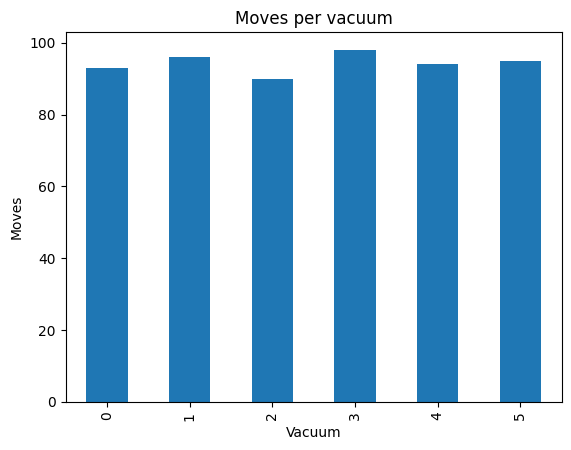

In [4]:
# Get the data of the agents
agent_data = model.datacollector.get_agent_vars_dataframe()

# Get the moves of the agents
end_moves = agent_data.xs(last_step, level="Step")["Moves"]

# Bar chart for each agent
plt = end_moves.plot(kind="bar")

# Label the axes
plt.set_title("Moves per vacuum")
plt.set_xlabel("Vacuum")
plt.set_ylabel("Moves")


Igual podemos conocer los movimientos totales que se hicieron en todo el modelo.

In [10]:
# Print total moves
print("Total moves: ", end_moves.sum())

Total moves:  566


Asimismo se puede obtener las veces que cada aspiradora limpio una celda durante todo el modelo.

Text(0, 0.5, 'Cells cleaned')

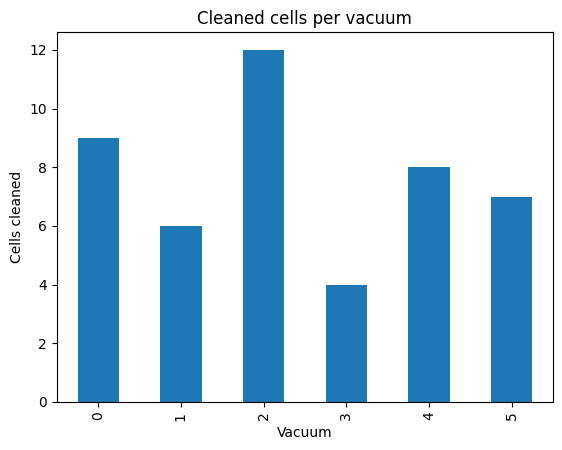

In [13]:
end_cleaned_cells = agent_data.xs(last_step, level="Step")["Cells cleaned"]

# Bar chart for each agent
plt = end_cleaned_cells.plot(kind="bar")

# Label the axes
plt.set_title("Cleaned cells per vacuum")
plt.set_xlabel("Vacuum")
plt.set_ylabel("Cells cleaned")

# Batch runner

Como este modelo es no determinista (estocástico) con un simple modelo no basta para obtener información relevante por lo que se generarán multiples modelos con diferentes parámetros con la ayuda de BatchRunner.

Los parámetros que utilizaremos son los mismo que el modelo anterior, unicamente se variará el número de aspiradoras a generar. Este número irá desde `10` a `30` aumentando un valor de 5, generando que se creen `5 modelos`.

In [14]:
from VacuumModel import VacuumModel
import mesa

# Create the model
# Batch run parameters
fixed_params = {
    "width": 10,
    "height": 10,
    "N": range(10, 31, 5),
    "dirtyCells": 0.5,
    "max_steps": 101,
}

# Save batch run data
batch_run = mesa.batch_run(
    VacuumModel,
    parameters=fixed_params,
    iterations=10,
    #max_steps=101,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

100%|██████████| 50/50 [00:00<00:00, 101.07it/s]


In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Get the data of the model
results_df = pd.DataFrame(batch_run)
# print(results_df.keys())

Con el conocimiento que tenemos hasta ahora podemos inferir que entre más aspiradoras se generen en el ambiente se ocuparan menos turnos para limpiar todas las celdas. Con la información recopilada podemos confirmar esto, pues la siguiente gráfica muestra como el modelo que tuvo `30 aspiradoras` solamente necesito aproximadamente `30 turnos` mientras que el modelo con `10 aspiradoras` generó más de `70 turnos`.

Text(0, 0.5, 'Last step')

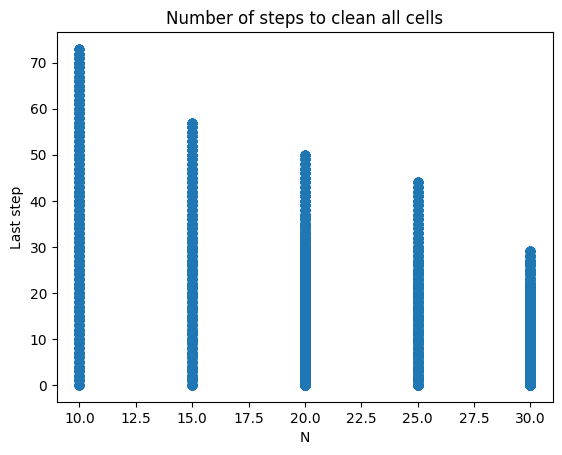

In [16]:
# Get the last step of each run different from 101
last_step = results_df.groupby("RunId")["Step"].max()
last_step = last_step[last_step <= 100]

# print("Last step: ", last_step.values)

N_values = results_df["N"].unique()
# print("N values: ", N_values)

# Get the data filtered
results_filtered = results_df[results_df["RunId"].isin(last_step.values) & 
                            results_df["N"].isin(N_values)]

N_values_plot = results_filtered.N.values
# print("N values plot: ", N_values_plot)
last_step_plot = results_filtered.Step.values
# print("Last step plot: ", last_step_plot)

# Plot
plt.plot(N_values_plot, last_step_plot, "o")
plt.title("Number of steps to clean all cells")
plt.xlabel("N")
plt.ylabel("Last step")


También podemos saber que cada aspiradora tuvo que aspirar en menos ocasiones cuando se inicializaban más robots limpiadores. En el caso de la `aspiradora 0` limpió `12 celdas` cuando se generaron `10 agentes` limpiadores, mientras que cuando se generaron `30 agentes` solamente limpio `2 celdas`.

Text(0, 0.5, 'Cells cleaned')

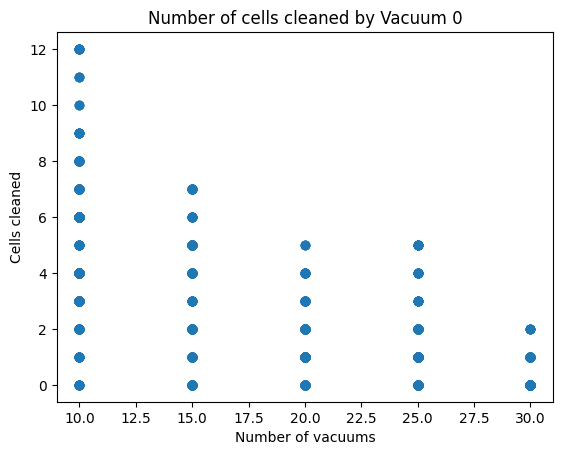

In [20]:
# Plot the number of times the Agent 0 cleaned a cell
agent_0_data = results_df[results_df["AgentID"] == 0]

# bar chart
plt.plot(agent_0_data.N.values, agent_0_data["Cells cleaned"].values, "o")
plt.title("Number of cells cleaned by Vacuum 0")
plt.xlabel("Number of vacuums")
plt.ylabel("Cells cleaned")

Liga al [código](https://github.com/sofhdez/TC2008B_351-Multiagentes) en Github